# Preparations

In [1]:
# Package Import 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import helper_functions as hf

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# imputation
!pip install MissForest
from missforest.missforest import MissForest

# ML
import statsmodels.api as sm
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Models
from sklearn.linear_model import PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor

# supress some annoying warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


## Data Import

In [2]:
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')
train.shape

(10886, 12)

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
print('Start Train: ', train['datetime'].min())
print('End Train: ', train['datetime'].max())
print('Start Test: ', test['datetime'].min())
print('End Test: ', test['datetime'].max())

Start Train:  2011-01-01 00:00:00
End Train:  2012-12-19 23:00:00
Start Test:  2011-01-20 00:00:00
End Test:  2012-12-31 23:00:00


## Data Cleaning

### Datatype and Variable Correction

Dtypes shows that some of the categorical variables are in int (season, holiday, workingday and weather) and datetime is not in datetime format. I need to correct that for later visualisations.Furthermore, the target variable is called count. This can lead to problems with some of my visualisations. Therefore, I rename it in total_shared. 

In [6]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [7]:
convert_dict = {'season': 'category',
                'holiday': bool,
                'workingday': bool,
                'weather': 'category'
                }

train = train.astype(convert_dict)
test = test.astype(convert_dict)
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.rename(columns={'count':'total_shared'}, inplace=True)
train.dtypes

datetime        datetime64[ns]
season                category
holiday                   bool
workingday                bool
weather               category
temp                   float64
atemp                  float64
humidity                 int64
windspeed              float64
casual                   int64
registered               int64
total_shared             int64
dtype: object

### Outliers

The boxplot indicates that multiple columns might have outliers. However, it does not tell us, whether those outliers are erroneous. Only erroneous outliers might be directly removed ([Aguinis et al., 2013](https://hermanaguinis.com/pdf/ORMoutliers.pdf)).

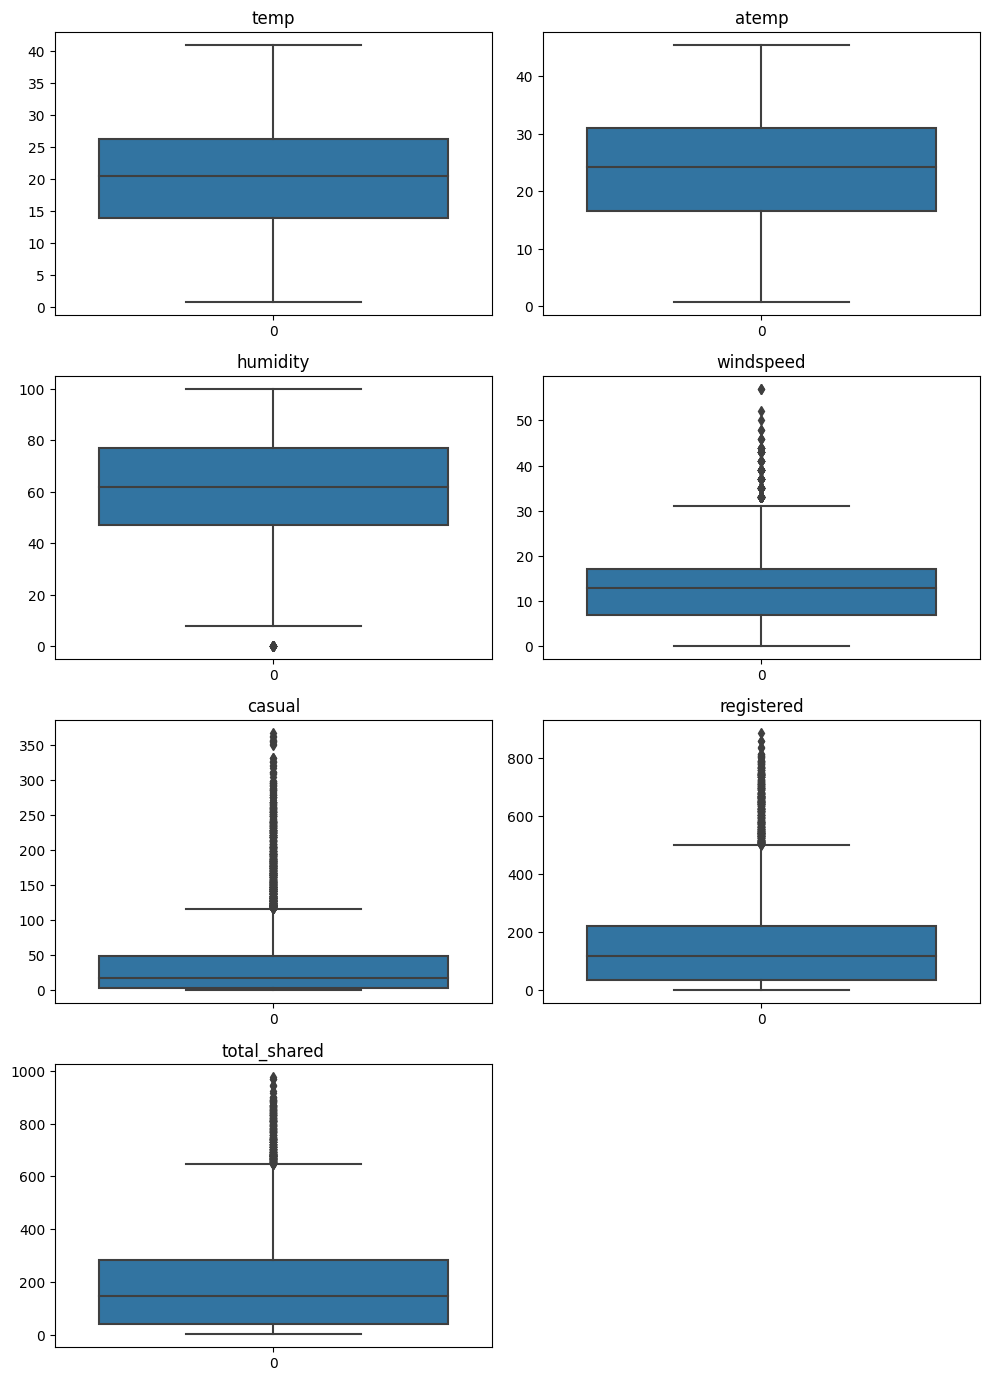

In [8]:
hf.boxplot_num(train)

What we in the scatterplot is that windspeed, casual, registered and total_shared all have long tails. Therefore, the upper values should not be seen as outliers. 
However, we see that registered, windspeed and humidity have zero values, which apparently do not stem from the underlying distribution. For atemp, we have one value which might be part of the distirbution, but occured suspiciously often.

For humidity and windspeed I would assume that these are failures of the measurement system. Atemp is a curious case. The value in itself is not surprising, however the amount of times that it was computes is curious. 

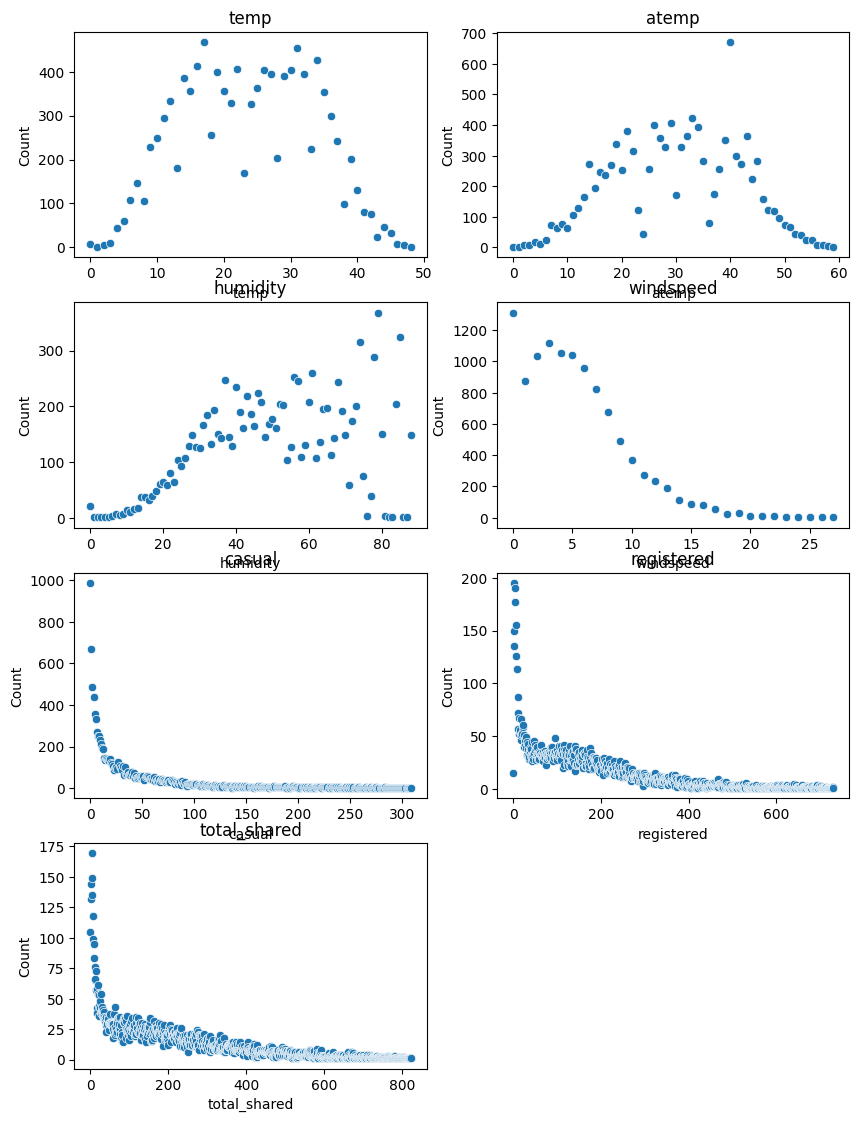

In [9]:
hf.scatter_num(train)

In [10]:
print('Mode: ', train['atemp'].mode()[0])

print('Times :', sum(train['atemp'] == train['atemp'].mode()[0]))

Mode:  31.06
Times : 671


The feels like temperature is calculated through temperature, humidity and windspeed. Therefore, it might be, that in cases where it could not be calculated (because one is missing), a standard value was chosen. However, I see that only for 72 atemp cases we can account with this explanation. However, 31.06 seems to be around 200 cases above the actual level.

In [11]:
sum((train['humidity'] == 0) & (train['atemp'] == 31.06))

0

In [12]:
sum((train['windspeed'] == 0) & (train['atemp'] == 31.06))

78

It is also not a specific temperature or date. 

In [13]:
train[train['atemp'] == 31.06].groupby('temp')['temp'].count()

temp
24.60    145
25.42    141
26.24    158
27.06    222
27.88      5
Name: temp, dtype: int64

<Axes: xlabel='datetime'>

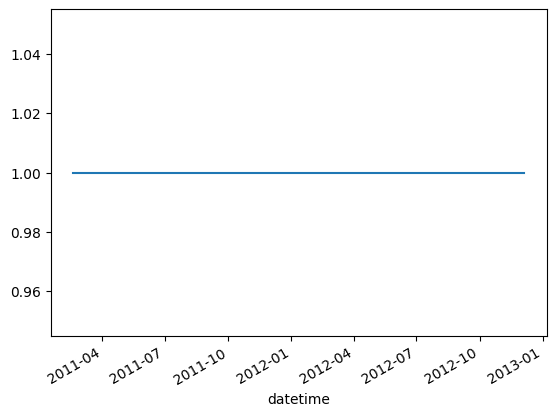

In [14]:
train[train['atemp'] == 31.06].groupby('datetime')['datetime'].count().plot()

It is not clear what causes the atemp outlier, therefore, I will create a new variable called atemp_imp in which I impute atemp and check whether it leads to better predictions. 

For registered, I want to investigate the reasons further. It could be that they belong to a specific group, for example a specific time period. However, as the following table shows, this is not the case. Therefore, I will keep them in the dataset. 

In [15]:
train.loc[train['registered'] < 1, :]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_shared
6,2011-01-01 06:00:00,1,False,False,1,9.02,13.635,80,0.0000,2,0,2
210,2011-01-10 01:00:00,1,False,True,1,4.92,6.060,50,19.0012,1,0,1
456,2011-02-02 02:00:00,1,False,True,3,9.02,11.365,93,8.9981,4,0,4
905,2011-03-02 04:00:00,1,False,True,1,8.20,10.605,75,8.9981,1,0,1
953,2011-03-04 04:00:00,1,False,True,2,7.38,9.090,74,12.9980,1,0,1
1023,2011-03-07 04:00:00,1,False,True,1,8.20,7.575,80,35.0008,1,0,1
1045,2011-03-08 02:00:00,1,False,True,1,9.84,12.120,52,8.9981,1,0,1
1091,2011-03-10 00:00:00,1,False,True,3,13.94,15.910,0,16.9979,3,0,3
1375,2011-04-03 04:00:00,2,False,False,1,11.48,15.150,70,6.0032,3,0,3
1398,2011-04-04 03:00:00,2,False,True,1,15.58,19.695,66,19.0012,1,0,1


I will delete the outlier from humidity and windspeed and create a new variable 'atemp_imp', in which I delete the mode value. All three will be imputed in the next step. 

In [16]:
train.loc[train['humidity'] == 0, 'humidity'] = np.nan
train.loc[train['windspeed'] == 0, 'windspeed'] = np.nan
train['atemp_imp'] = np.where(train['atemp'] == 31.06, np.nan, train['atemp'])

test.loc[test['humidity'] == 0, 'humidity'] = np.nan
test.loc[test['windspeed'] == 0, 'windspeed'] = np.nan
test['atemp_imp'] = np.where(test['atemp'] == 31.06, np.nan, test['atemp'])

### Missings and Duplicates

There are no duplicates.

In [17]:
sum(train.duplicated())

0

However, thanks to outlier removal, there are three columns with missings, which need to be imputed. I use random forest imputation for that, because it lead to promsising results previously (e.g. [1](https://doi.org/10.3390/rs13122312), [2](https://academic.oup.com/bioinformatics/article/28/1/112/219101))

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  category      
 2   holiday       10886 non-null  bool          
 3   workingday    10886 non-null  bool          
 4   weather       10886 non-null  category      
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10864 non-null  float64       
 8   windspeed     9573 non-null   float64       
 9   casual        10886 non-null  int64         
 10  registered    10886 non-null  int64         
 11  total_shared  10886 non-null  int64         
 12  atemp_imp     10215 non-null  float64       
dtypes: bool(2), category(2), datetime64[ns](1), float64(5), int64(3)
memory usage: 808.5 KB


In [19]:
temp = train.iloc[:, list(range(1,9)) + [12]]
from missforest.missforest import MissForest
imputer = MissForest()
temp_imp = imputer.fit_transform(temp, categorical = ['holiday', 'workingday',
                                                      'season', 'weather'])
train.loc[:,['humidity', 
             'windspeed', 
             'atemp_imp']] = temp_imp[['humidity', 'windspeed', 'atemp_imp']]
train.info()

100%|██████████| 5/5 [00:01<00:00,  2.66it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10886 non-null  datetime64[ns]
 1   season        10886 non-null  category      
 2   holiday       10886 non-null  bool          
 3   workingday    10886 non-null  bool          
 4   weather       10886 non-null  category      
 5   temp          10886 non-null  float64       
 6   atemp         10886 non-null  float64       
 7   humidity      10886 non-null  float64       
 8   windspeed     10886 non-null  float64       
 9   casual        10886 non-null  int64         
 10  registered    10886 non-null  int64         
 11  total_shared  10886 non-null  int64         
 12  atemp_imp     10886 non-null  float64       
dtypes: bool(2), category(2), datetime64[ns](1), float64(5), int64(3)
memory usage: 808.5 KB


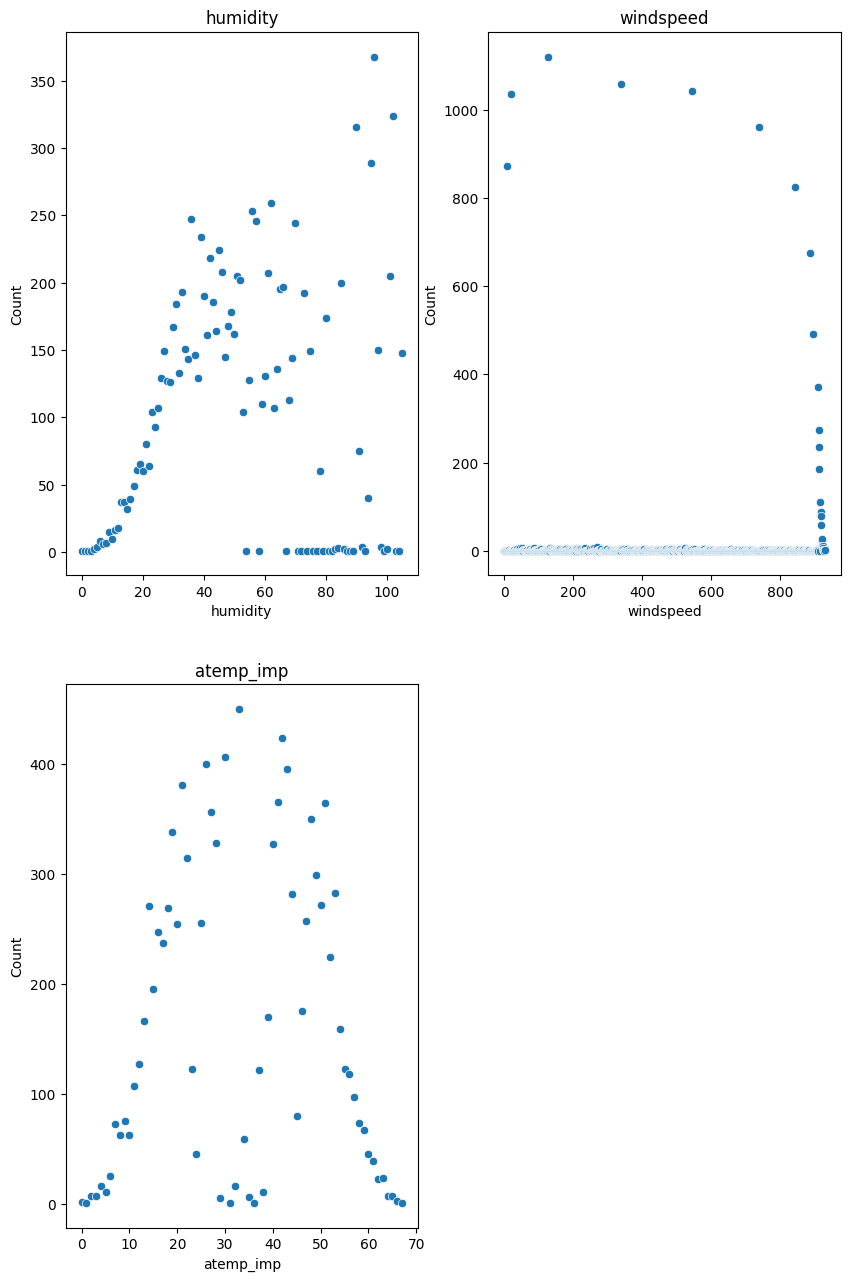

In [20]:
hf.scatter_num(train, features = ['humidity', 'windspeed', 'atemp_imp'])

In [21]:
temp_imp = imputer.transform(test.iloc[:,1:])
test.loc[:,['humidity', 
             'windspeed', 
             'atemp_imp']] = temp_imp[['humidity', 'windspeed', 'atemp_imp']]
test.info()

100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    6493 non-null   datetime64[ns]
 1   season      6493 non-null   category      
 2   holiday     6493 non-null   bool          
 3   workingday  6493 non-null   bool          
 4   weather     6493 non-null   category      
 5   temp        6493 non-null   float64       
 6   atemp       6493 non-null   float64       
 7   humidity    6493 non-null   float64       
 8   windspeed   6493 non-null   float64       
 9   atemp_imp   6493 non-null   float64       
dtypes: bool(2), category(2), datetime64[ns](1), float64(5)
memory usage: 330.2 KB


## Data Integration
Here not necessity.

## Feature Creation

In [22]:
for dataset in [train, test]:
    # Datetime Handling
    dataset['time'] = dataset['datetime'].dt.time
    dataset['date'] = dataset['datetime'].dt.date
    dataset['hour'] = dataset['datetime'].dt.hour
    dataset['month'] = dataset['datetime'].dt.month
    dataset['day'] = dataset['datetime'].dt.weekday
    dataset['year'] = dataset['datetime'].dt.year

In [23]:
train.dtypes

datetime        datetime64[ns]
season                category
holiday                   bool
workingday                bool
weather               category
temp                   float64
atemp                  float64
humidity               float64
windspeed              float64
casual                   int64
registered               int64
total_shared             int64
atemp_imp              float64
time                    object
date                    object
hour                     int32
month                    int32
day                      int32
year                     int32
dtype: object

# Data Exploration

## Univariate

In [24]:
train.describe(include = ['object', 'bool'])

,holiday,workingday,time,date
count,10886,10886,10886,10886
unique,2,2,24,456
top,False,True,16:00:00,2012-12-19
freq,10575,7412,456,24


In [25]:
train.describe()

,datetime,temp,atemp,humidity,windspeed,casual,registered,total_shared,atemp_imp,hour,month,day,year
count,10886,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,20.23086,23.655084,62.047204,14.238156,36.021955,155.552177,191.574132,23.141384,11.541613,6.521495,3.013963,2011.501929
min,2011-01-01 00:00:00,0.82000,0.760000,8.000000,3.146280,0.000000,0.000000,1.000000,0.760000,0.000000,1.000000,0.000000,2011.000000
25%,2011-07-02 07:15:00,13.94000,16.665000,47.000000,8.998100,4.000000,36.000000,42.000000,16.665000,6.000000,4.000000,1.000000,2011.000000
50%,2012-01-01 20:30:00,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,22.725680,12.000000,7.000000,3.000000,2012.000000
75%,2012-07-01 12:45:00,26.24000,31.060000,77.445775,17.462907,49.000000,222.000000,284.000000,29.545000,18.000000,10.000000,5.000000,2012.000000
max,2012-12-19 23:00:00,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,45.455000,23.000000,12.000000,6.000000,2012.000000
std,NaN,7.79159,8.474601,19.060071,6.780145,49.960477,151.039033,181.144454,8.260026,6.915838,3.444373,2.004585,0.500019


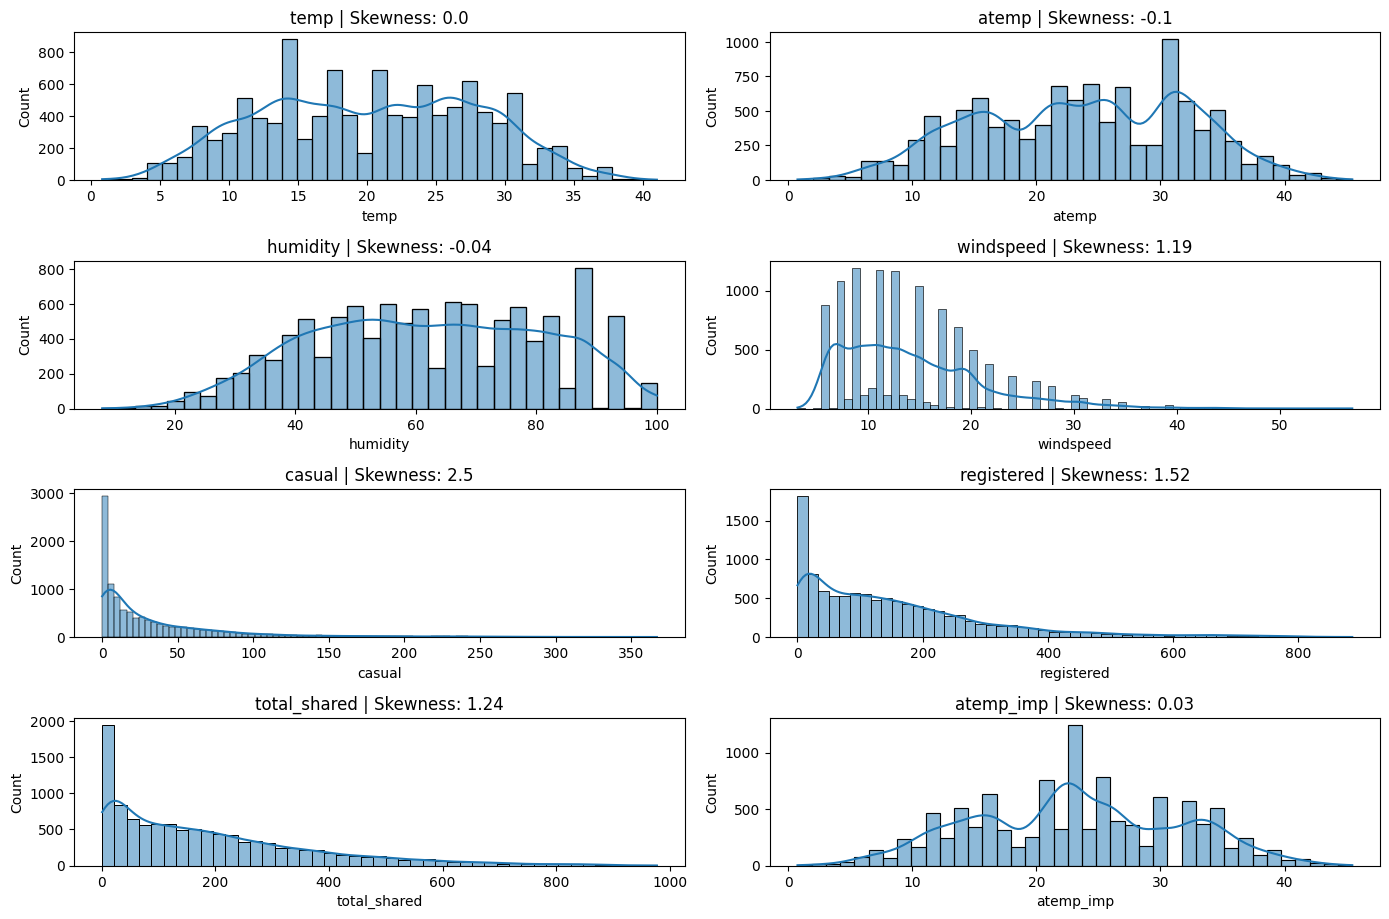

In [26]:
hf.hist_numerical(train)

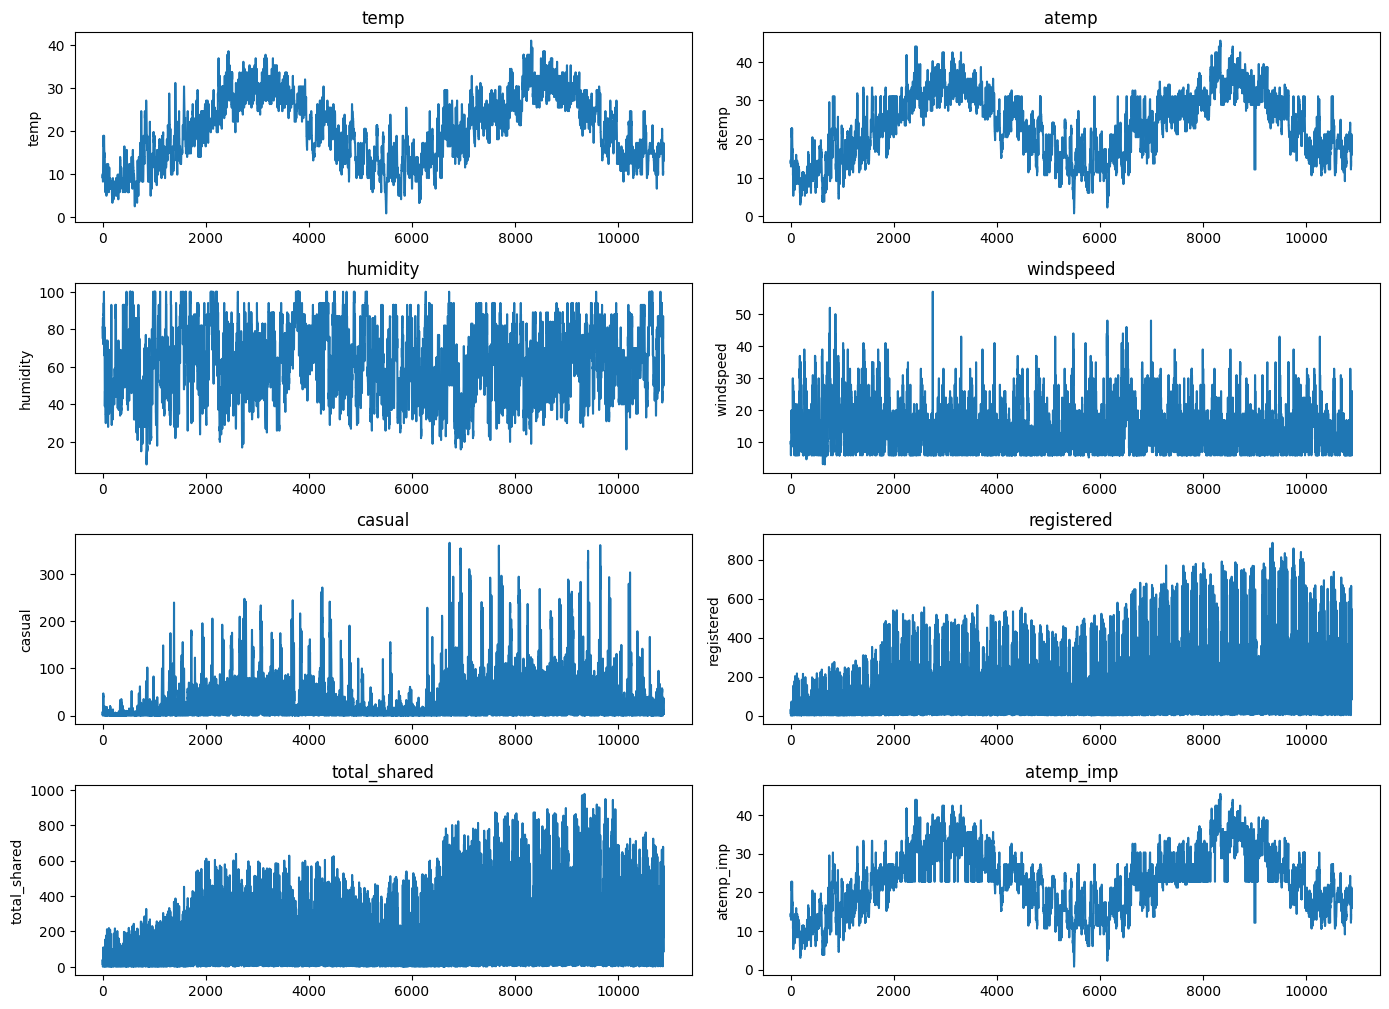

In [27]:
hf.trends_numerical(train)

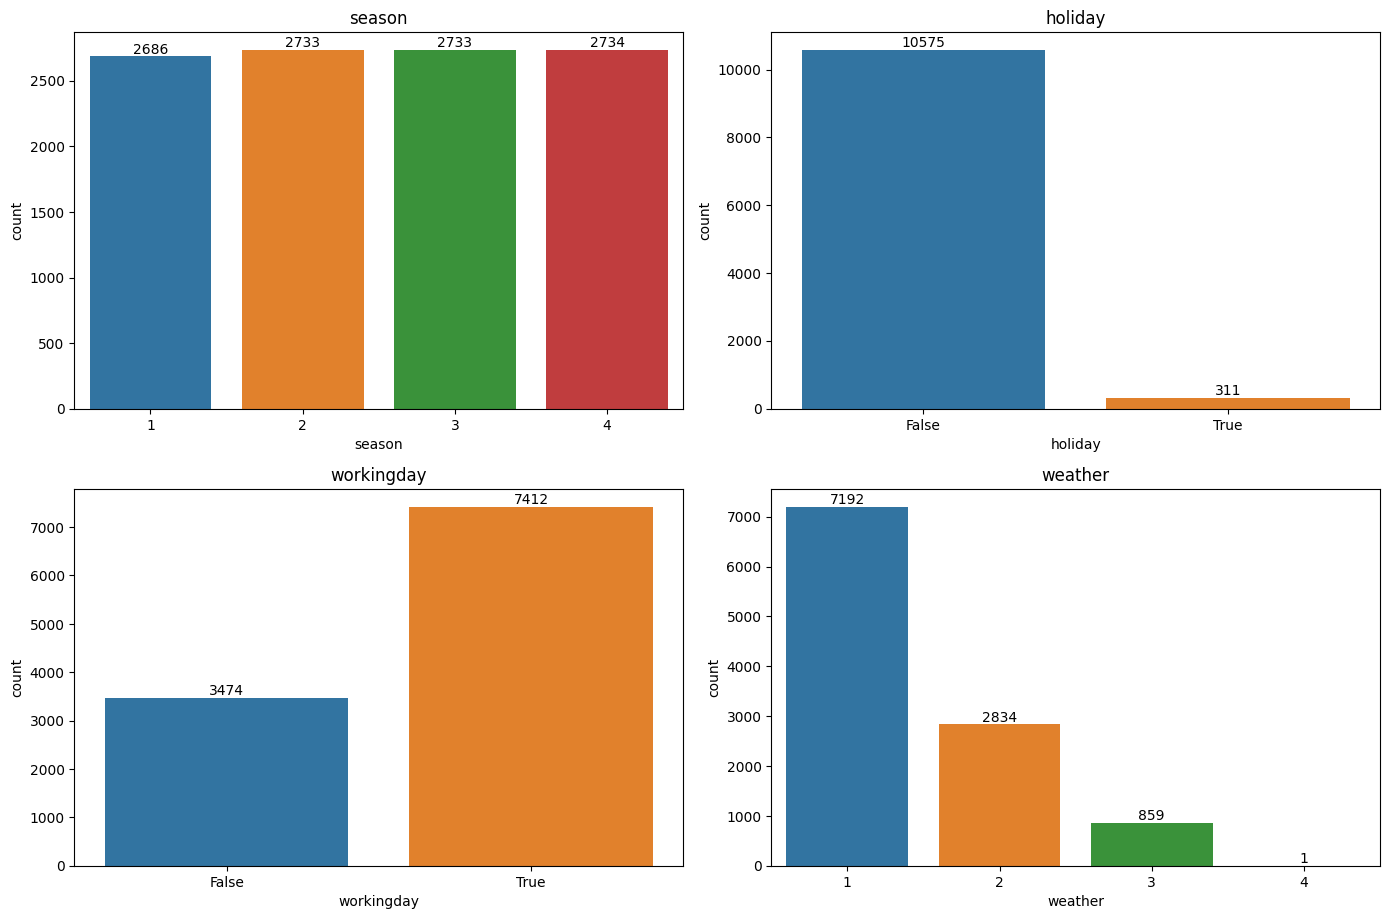

In [28]:
features = ['season', 'holiday', 'workingday', 'weather']
hf.countplot_all(train, features)

## Bivariate

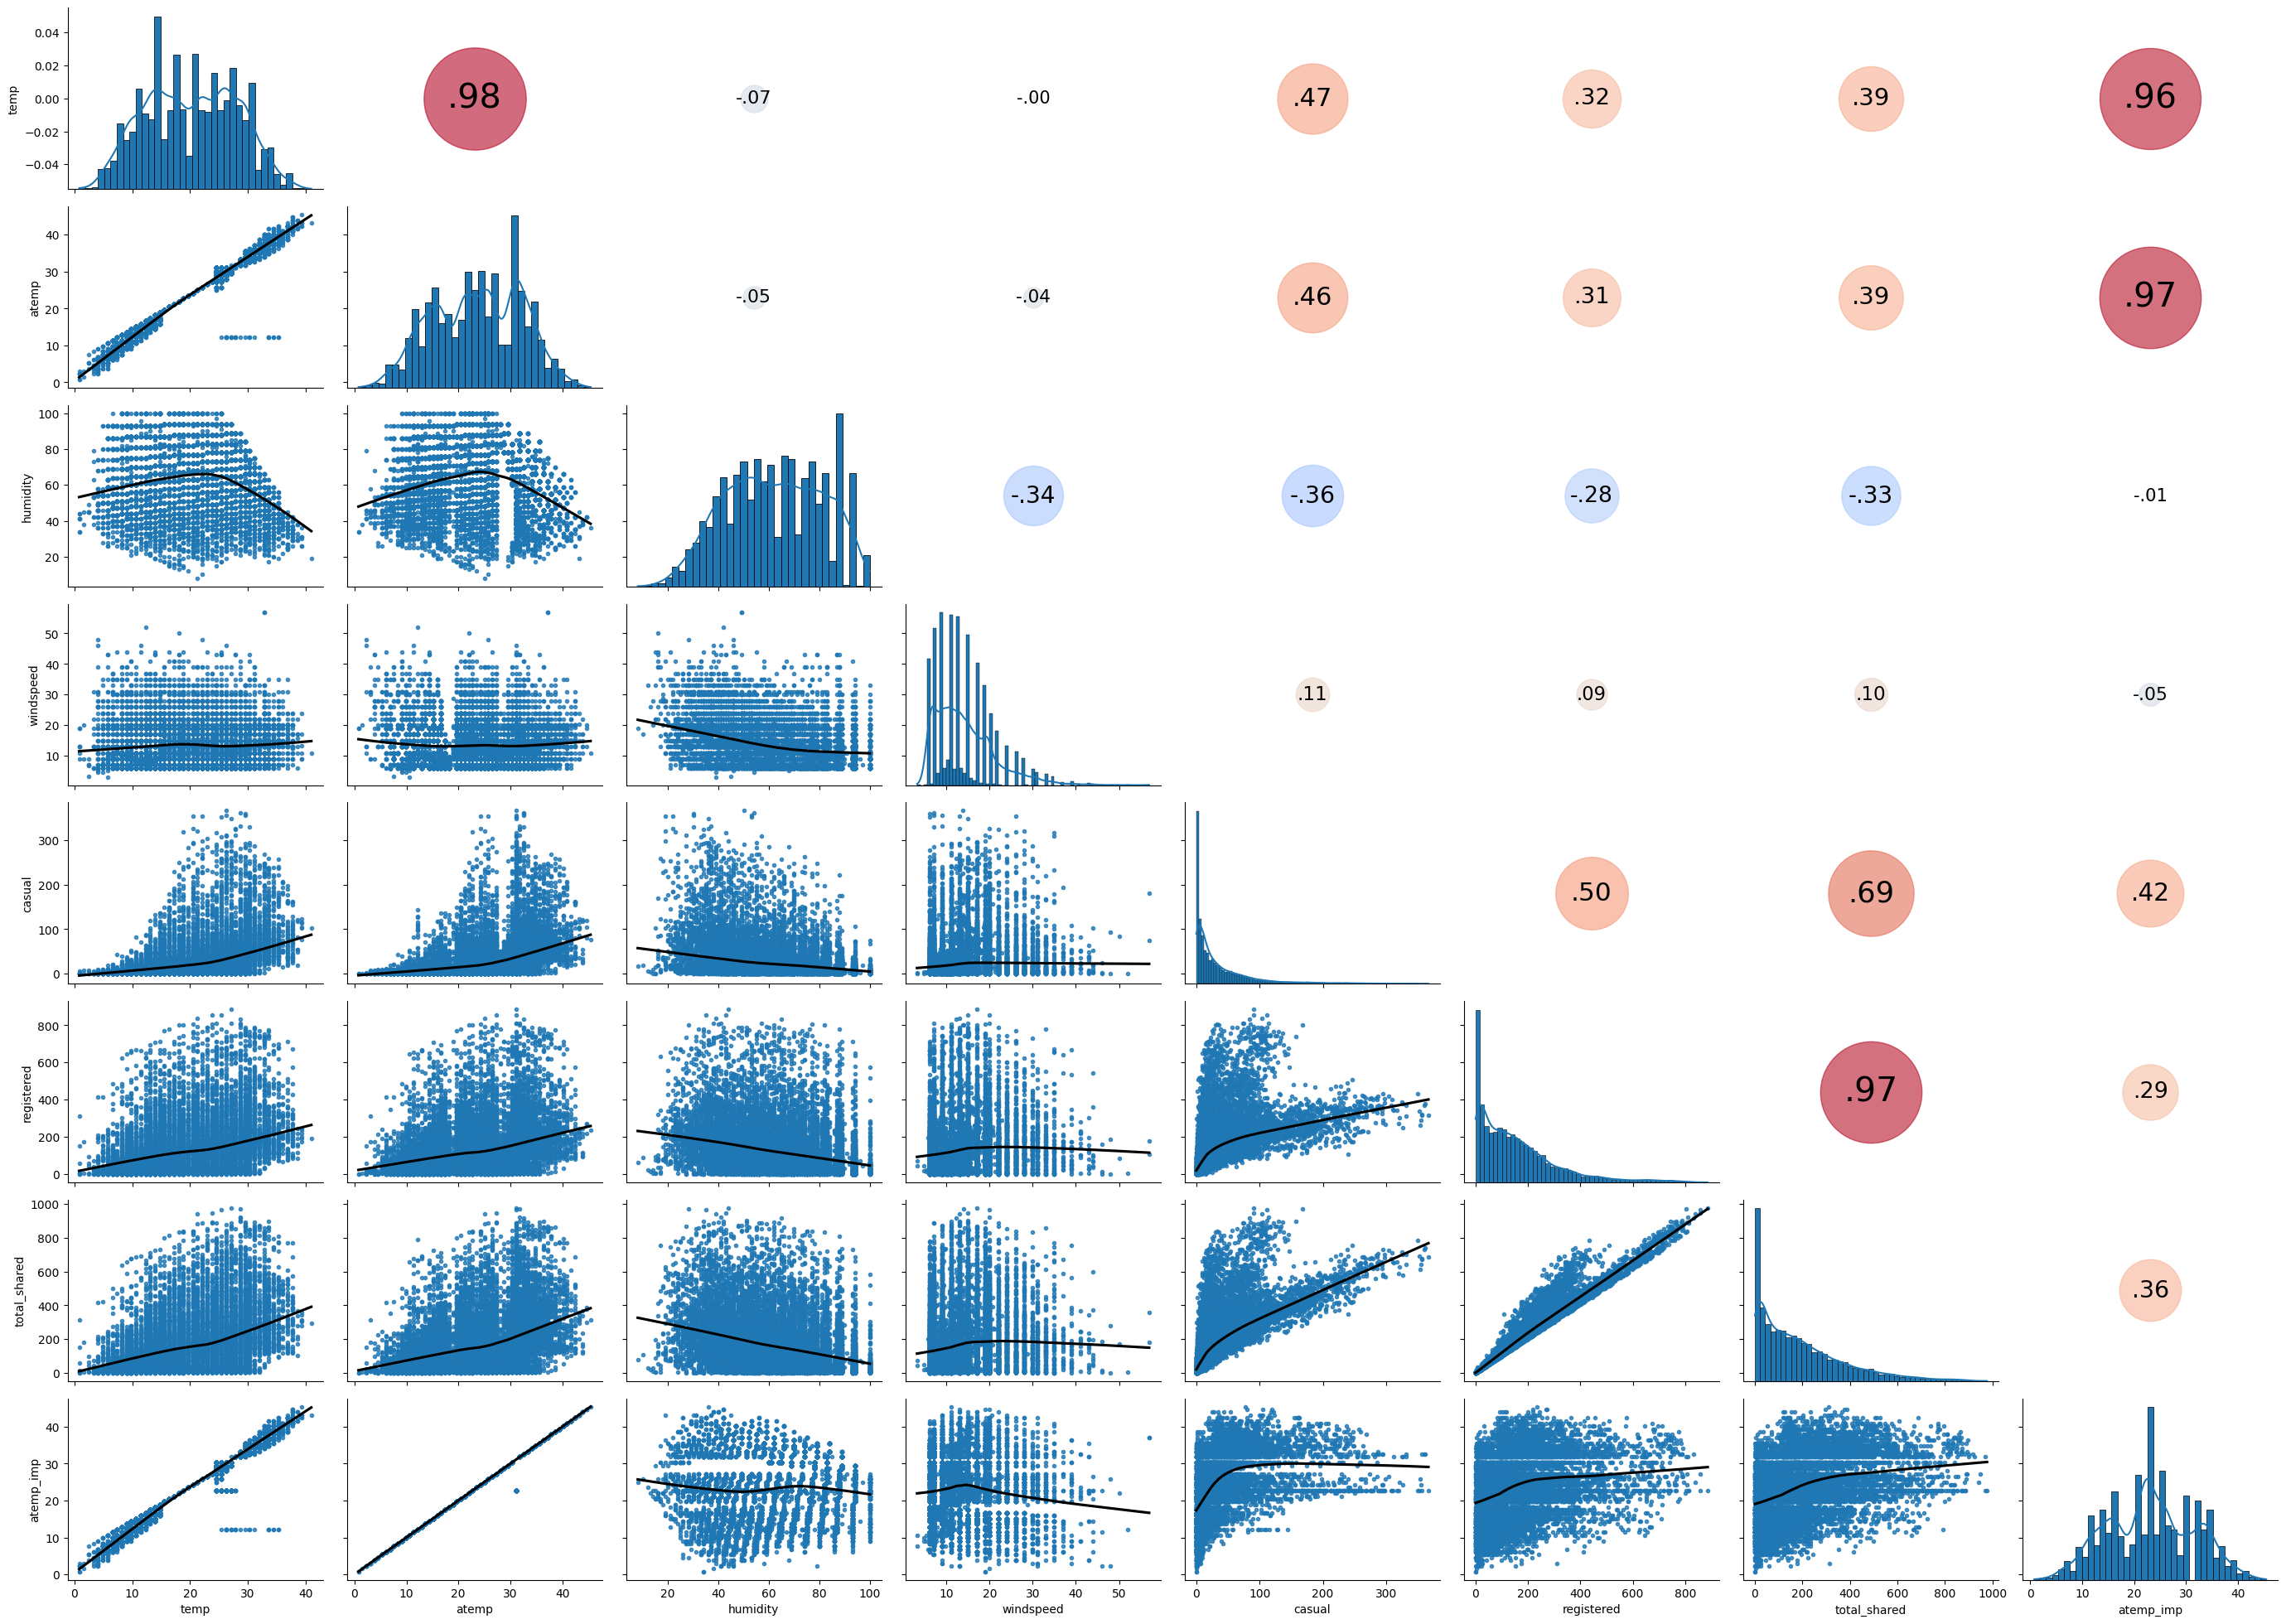

In [29]:
hf.pair_plot(train)

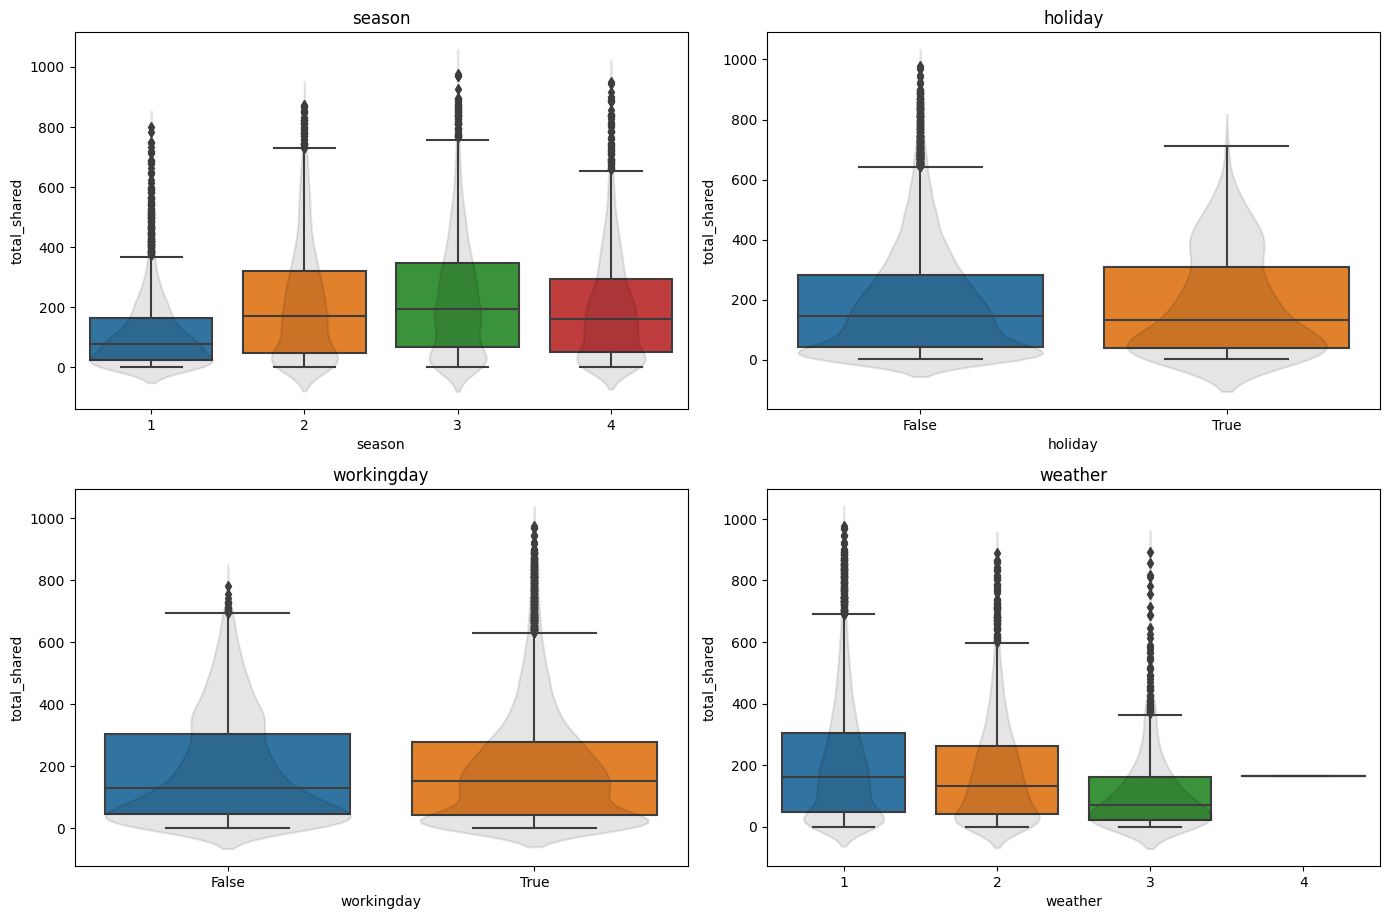

In [30]:
features = ['season', 'holiday', 'workingday', 'weather']
hf.boxplot_cat(train, y = 'total_shared', features = features)

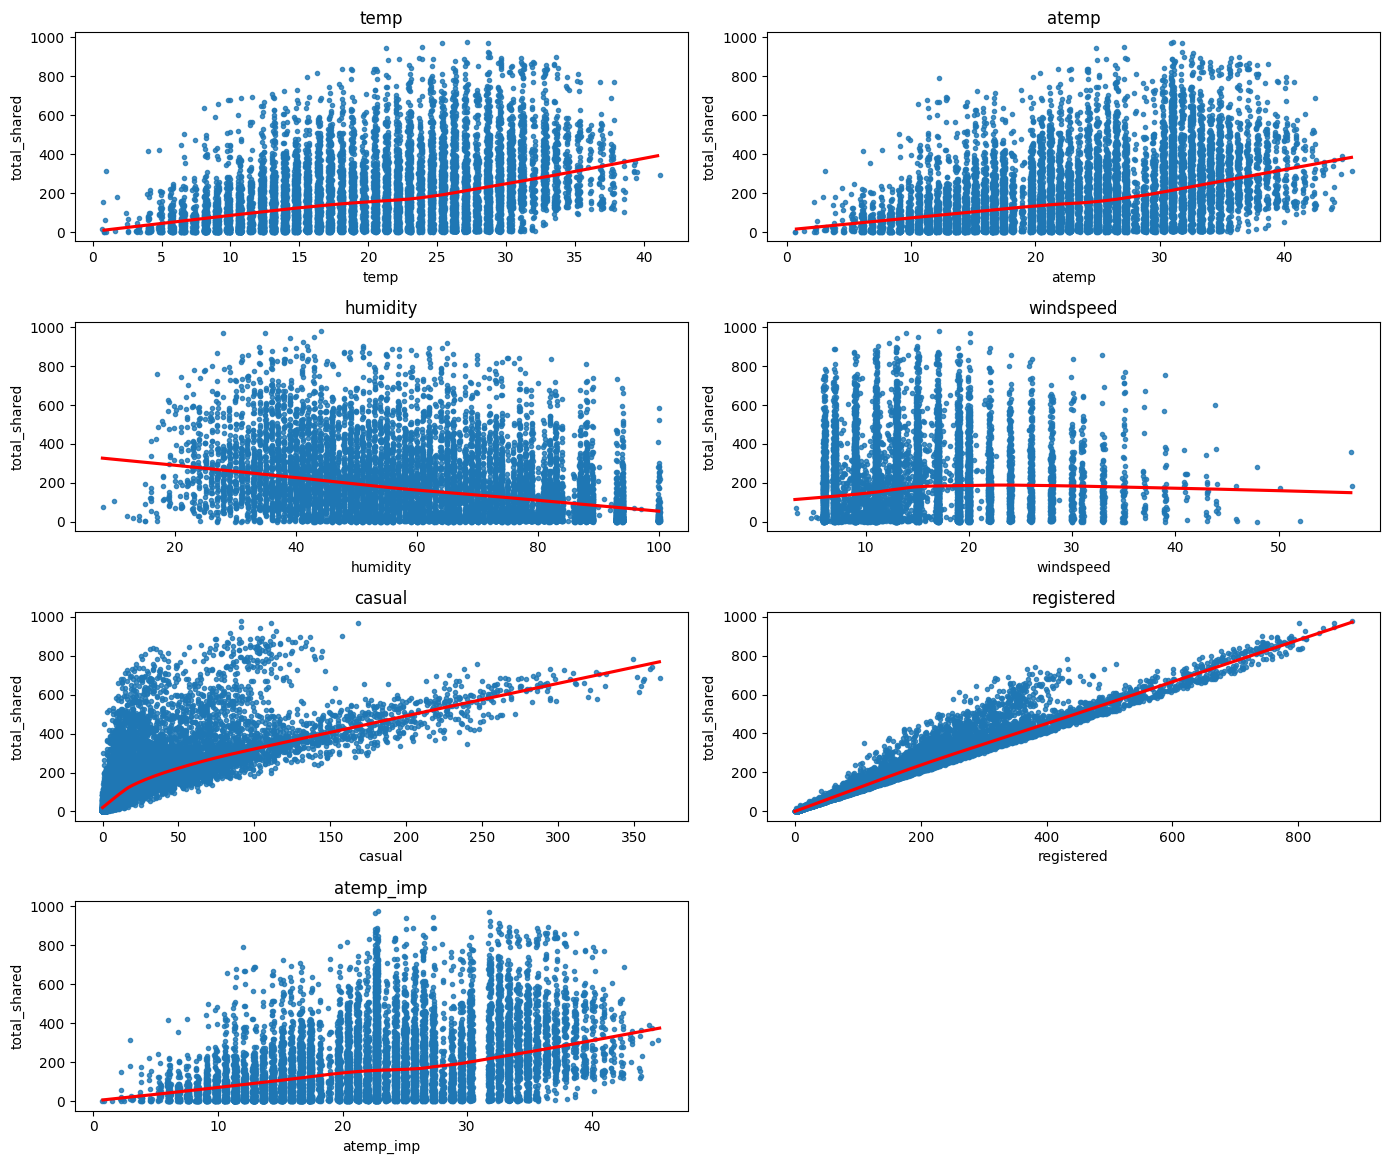

In [31]:
hf.rel_plots(train, y = 'total_shared')

Time Plots

<Axes: xlabel='hour', ylabel='total_shared'>

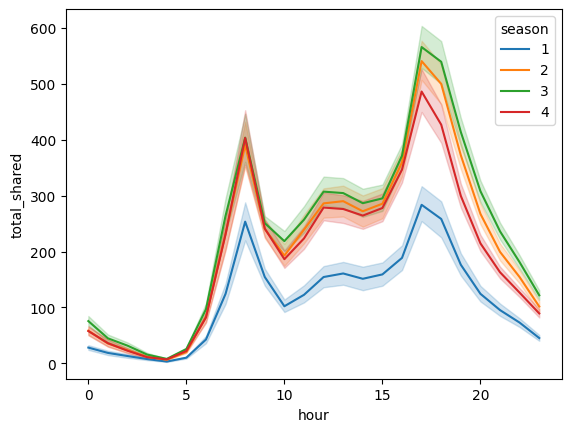

In [32]:
sns.lineplot(x="hour", y="total_shared", data=train, hue = 'season')

<Axes: xlabel='hour', ylabel='total_shared'>

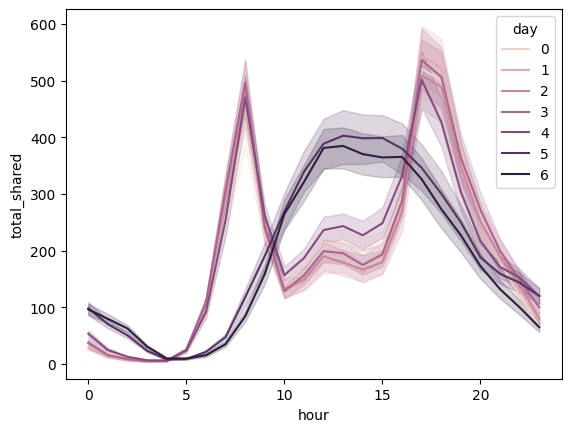

In [33]:
sns.lineplot(x="hour", y="total_shared", data=train, hue = 'day')

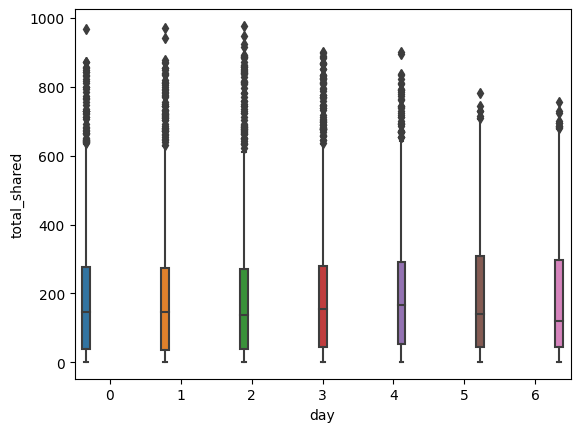

In [34]:
p = sns.boxplot(x="day", y="total_shared", data=train, hue = 'day')
p.get_legend().remove()

<Axes: xlabel='month', ylabel='total_shared'>

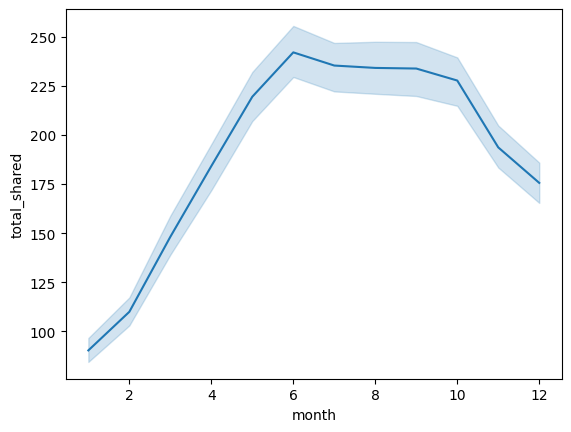

In [35]:
sns.lineplot(x='month', y="total_shared", data=train)

# Model Building 

## Encoding

In [36]:
y = train['total_shared']
X = train.loc[:, ~train.columns.isin(['casual', 
                                      'registered', 
                                      'total_shared',
                                     'datetime',
                                     'time',
                                     'atemp',
                                     'date'])]


In [37]:
X.shape

(10886, 12)

In [38]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_include="number")),
        ('cat', OneHotEncoder(), selector(dtype_include="category"))],
                                remainder='passthrough')
X = column_trans.fit_transform(X)
X[0]

array([0.2244898 , 0.79347826, 0.12165873, 0.30506768, 0.        ,
       0.        , 0.83333333, 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [39]:
X.shape

(10886, 18)

In [40]:
column_trans.get_feature_names_out()

array(['num__temp', 'num__humidity', 'num__windspeed', 'num__atemp_imp',
       'num__hour', 'num__month', 'num__day', 'num__year',
       'cat__season_1', 'cat__season_2', 'cat__season_3', 'cat__season_4',
       'cat__weather_1', 'cat__weather_2', 'cat__weather_3',
       'cat__weather_4', 'remainder__holiday', 'remainder__workingday'],
      dtype=object)

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1984)

## Model Selection
Subsequently I test different models, to select the ones which work best for Hyperparameter tuning. The structure and much of the code is taken from https://dataknowsall.com/blog/modelselection.html

### Candidate Models
Because of the Poisson Distribution, I wanted to use Poisson Regression. The others are models which are known to perform well for regression or performed well for other Kagglers on this task. And I included KNR. 

In [42]:
def get_models():
    models = dict()

    models['Poisson Regression Poly'] = Pipeline([
        ('preprocessor', PolynomialFeatures(degree=3)),
        ('model', PoissonRegressor(max_iter=1000))])
    
    models['Poisson Regression Spline'] = Pipeline([
        ('preprocessor', SplineTransformer()),
        ('model', PoissonRegressor(max_iter=1000))])
    
    models['Nearest Neighbor'] = Pipeline([ 
        ('model', KNeighborsRegressor())])
    
    models['Decision Tree'] = Pipeline([ 
        ('model', DecisionTreeRegressor())])

    models['Random Forest'] = Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, 
                                       verbose = 0))])

    models['Gradient Boosting'] = Pipeline([ 
        ('model', HistGradientBoostingRegressor(verbose = 0))]) # Hist because of large dataset


    models['Bagging'] = Pipeline([
        ('model', BaggingRegressor(n_estimators=100, verbose = 0))])
    
    models['XGBOOST'] = Pipeline([ 
        ('model', XGBRegressor())])

    return models

### Evaluation Method
I am supposed to use the root_mean_squared_lor_error. For that I needed to create an extra scorer. I use CV, to get a more nuanced picture of the performance than a one-time run. 

In [43]:
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, 
                                 n_repeats=10, 
                                 random_state=1)
    def rmsle(y_true, y_pred):
        print(sum(y_pred < 0))
        y_pred[y_pred < 0] = 0
        return mean_squared_log_error(y_true, y_pred, squared = False)

    rmsle_scorer = make_scorer(rmsle) 

    scores = cross_val_score(model, X, y, 
                             scoring=rmsle_scorer, 
                             cv=cv, n_jobs=-1)
    return scores

### Model Selection Results

In [44]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    %time scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('* %s Score = %.3f StdDev = (%.3f)' % (name, 
np.mean(scores), np.std(scores)), '\n')

CPU times: user 757 ms, sys: 306 ms, total: 1.06 s
Wall time: 2min 1s
* Poisson Regression Poly Score = 1.017 StdDev = (0.021) 

CPU times: user 208 ms, sys: 21.2 ms, total: 229 ms
Wall time: 3.74 s
* Poisson Regression Spline Score = 0.973 StdDev = (0.020) 

CPU times: user 119 ms, sys: 7.49 ms, total: 127 ms
Wall time: 1.43 s
* Nearest Neighbor Score = 0.836 StdDev = (0.023) 

CPU times: user 109 ms, sys: 12.7 ms, total: 122 ms
Wall time: 907 ms
* Decision Tree Score = 0.436 StdDev = (0.014) 

CPU times: user 271 ms, sys: 45.1 ms, total: 316 ms
Wall time: 48.5 s
* Random Forest Score = 0.340 StdDev = (0.013) 

CPU times: user 203 ms, sys: 21.6 ms, total: 225 ms
Wall time: 10.4 s
* Gradient Boosting Score = 0.425 StdDev = (0.016) 

CPU times: user 268 ms, sys: 50.7 ms, total: 318 ms
Wall time: 49.7 s
* Bagging Score = 0.340 StdDev = (0.013) 

CPU times: user 205 ms, sys: 16.4 ms, total: 222 ms
Wall time: 3.61 s
* XGBOOST Score = 0.513 StdDev = (0.025) 



As the plot shows, Bagging works best. Random Forests and Gradient Boosting are second. 

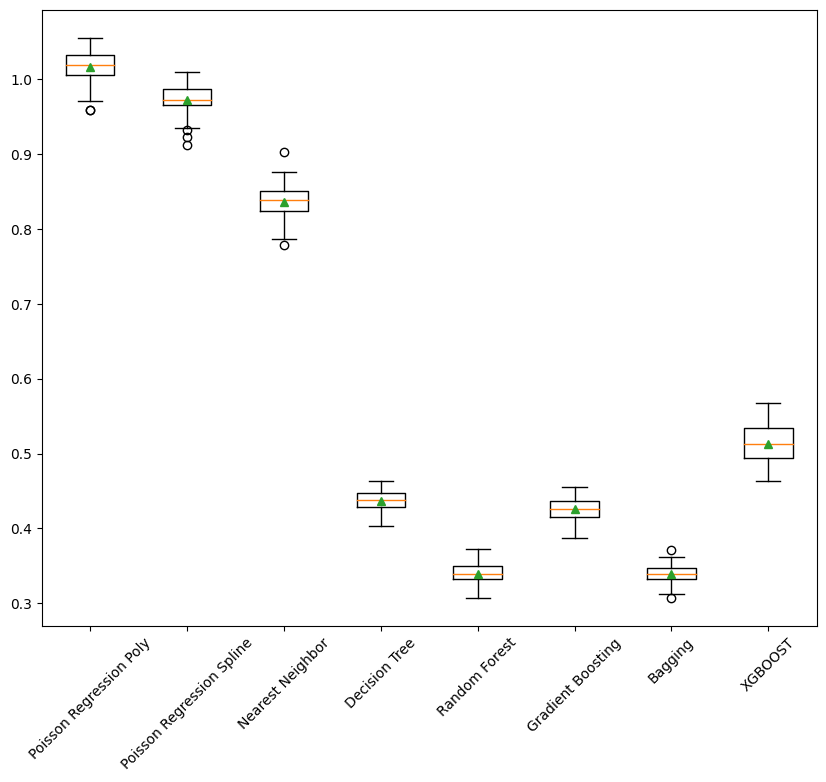

In [45]:
# plot model performance for comparison
plt.figure(figsize=(10,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

## Hyperparameter Tuning 

In [46]:
pipeline = Pipeline([
    ('model', BaggingRegressor())  
])

In [47]:
def rmsle(y_true, y_pred):
        print(sum(y_pred < 0))
        y_pred[y_pred < 0] = 0
        return mean_squared_log_error(y_true, y_pred, squared = False)

rmsle_scorer = make_scorer(rmsle, greater_is_better = False) 

**Rough Search**

Because there are too many possible parameter combinations, I try to reduce the search space first.

For bagging, I take the results in https://www.kaggle.com/code/juanmah/tactic-03-hyperparameter-optimization-bagging as orientation.

For Random Forest I used https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 as a source of inspiration

In [48]:
param_grid = [
    {
        'model': [BaggingRegressor()],
        'model__estimator': [PoissonRegressor(max_iter=1000),
                             DecisionTreeRegressor(), 
                             KNeighborsRegressor()],
        'model__n_estimators': [10, 500],
        'model__max_samples': [0.25, 1.0],
        'model__max_features': [0.25, 1.0],
        'model__bootstrap': [True, False]
    },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [10, 500],
        'model__criterion': ["squared_error", "friedman_mse"],
        'model__max_depth': [10, 100],
        'model__min_samples_leaf': [1,  4],
        'model__min_samples_split': [2, 10],
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False]
    }
]


In [49]:
grid = HalvingGridSearchCV(pipeline, 
                           param_grid, 
                           scoring=rmsle_scorer, 
                           cv=3, 
                           n_jobs = -1, 
                           verbose = 1, 
                           error_score='raise').fit(X_train, y_train)


print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 107
max_resources_: 8708
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 107
Fitting 3 folds for each of 240 candidates, totalling 720 fits
----------
iter: 1
n_candidates: 80
n_resources: 321
Fitting 3 folds for each of 80 candidates, totalling 240 fits
----------
iter: 2
n_candidates: 27
n_resources: 963
Fitting 3 folds for each of 27 candidates, totalling 81 fits
----------
iter: 3
n_candidates: 9
n_resources: 2889
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 8667
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best cross-validation accuracy: -0.348
0
Test set score: -0.314
Best parameters: {'model': BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=500), 'model__bootstrap': True, 'model__estimator': DecisionTreeRegressor(), 'model__max_features': 1.0, 'model__max_samples':

In [50]:
search_results = pd.DataFrame(grid.cv_results_)
for col in search_results.select_dtypes(include=['object']).columns:
    search_results[col] = search_results[col].astype(str)
search_results['param_model'] = search_results['param_model'].str.split("(").str[0]
search_results['param_model__estimator'] = search_results['param_model__estimator'].str[0:10]
search_results.columns

Index(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time',
       'mean_score_time', 'std_score_time', 'param_model',
       'param_model__bootstrap', 'param_model__estimator',
       'param_model__max_features', 'param_model__max_samples',
       'param_model__n_estimators', 'param_model__criterion',
       'param_model__max_depth', 'param_model__min_samples_leaf',
       'param_model__min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [51]:
cols = ['iter', 'param_model',
       'param_model__bootstrap', 'param_model__estimator',
       'param_model__max_features', 'param_model__max_samples',
       'param_model__n_estimators', 'param_model__criterion',
       'param_model__max_depth', 'param_model__min_samples_leaf',
       'param_model__min_samples_split', 'params','mean_test_score',
       'std_test_score', 'rank_test_score']
search_results[cols].sort_values('rank_test_score').head(10)

,iter,param_model,param_model__bootstrap,param_model__estimator,param_model__max_features,param_model__max_samples,param_model__n_estimators,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,mean_test_score,std_test_score,rank_test_score
358,4,BaggingRegressor,True,DecisionTr,1.0,1.0,500,nan,nan,nan,nan,{'model': BaggingRegressor(estimator=DecisionT...,-0.348092,0.005649,1
356,4,RandomForestRegressor,True,nan,None,nan,500,friedman_mse,100,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.348235,0.006466,2
357,4,RandomForestRegressor,True,nan,None,nan,500,squared_error,100,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.348498,0.006390,3
355,3,BaggingRegressor,True,DecisionTr,1.0,1.0,500,nan,nan,nan,nan,{'model': BaggingRegressor(estimator=DecisionT...,-0.428471,0.013575,4
354,3,RandomForestRegressor,True,nan,None,nan,500,squared_error,100,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.429053,0.014232,5
353,3,RandomForestRegressor,True,nan,None,nan,500,friedman_mse,100,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.429818,0.013602,6
352,3,RandomForestRegressor,True,nan,None,nan,500,friedman_mse,10,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.440638,0.014660,7
351,3,RandomForestRegressor,True,nan,None,nan,500,squared_error,10,1,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.441359,0.014635,8
347,3,RandomForestRegressor,True,nan,None,nan,500,squared_error,100,4,2,"{'model': RandomForestRegressor(), 'model__boo...",-0.445531,0.012633,9
349,3,BaggingRegressor,True,DecisionTr,1.0,1.0,10,nan,nan,nan,nan,{'model': BaggingRegressor(estimator=DecisionT...,-0.445603,0.004685,10


At first, I want a general comparison of those parameters, which pertain to both models. 

We see that **Bootstrap = True** is on average the better choice. All of the top ten models have Bootstrap = True, however, in more combinations bootstrap = False is the better choice. In sum, I will continue with Bootstrap = True. 

In regard to the **Estimators**, we see that the best 10 Models are either random forests or decision trees. They win in every combination and are similarly strong. Therefore, I will only tune those in the next round. 

500 seems to be closer to the optimal **Number of Estimators** than 10. 8 of the top ten models included 500 estimators, on average the performance is better and in most of the combinations, it performs better. Therefore, I will explore this area further.

param_model__bootstrap 

  param_model__bootstrap  mean_test_score
0                  False        -0.927216
1                   True        -0.920421 

{'True': 4, 'False': 4}


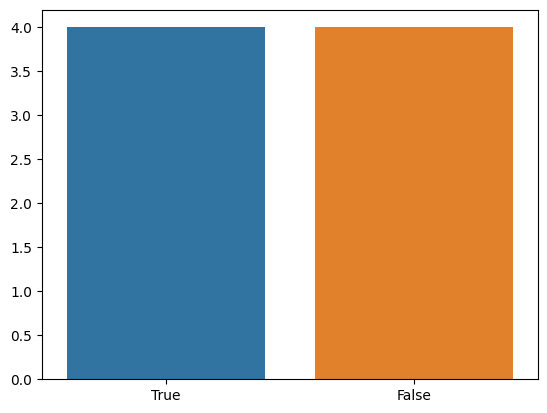

param_model__estimator 

  param_model__estimator  mean_test_score
0             DecisionTr        -0.919523
1             KNeighbors        -1.291204
2             PoissonReg        -1.164247
3                    nan        -0.892029 

{'PoissonReg': 0, 'DecisionTr': 4, 'KNeighbors': 0, 'nan': 4}


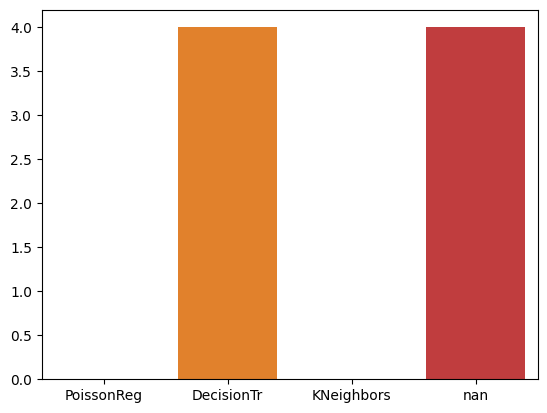

param_model__n_estimators 

  param_model__n_estimators  mean_test_score
0                        10         -0.94000
1                       500         -0.90886 

{'10': 2, '500': 6}


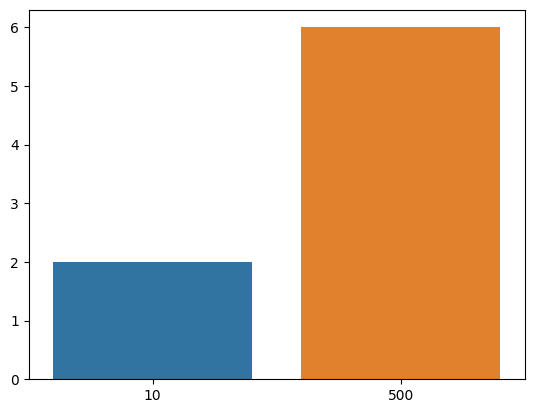

In [52]:
params = ['param_model', 'param_model__bootstrap', 'param_model__estimator',
       'param_model__n_estimators']

for param in params:
    if param == 'param_model':
        continue
    print(param,"\n")
    t = search_results.groupby(param)['mean_test_score'].mean().reset_index()
    print(t, "\n")
    feature_columns = [feature for feature in params if feature != param] 
    res = hf.optimal_config_count(search_results, feature_columns, 
                     param, 'mean_test_score')
    print(res)
    sns.barplot(x = list(res.keys()), y = list(res.values()))
    plt.show()

Next, I will explore the Bagging regressor combinations. In the top 10 ranking, the average scores and the amoutn of winned combinations, we we see that for samples and features, more means better. 

param_model__max_features 

  param_model__max_features  mean_test_score
0                      0.25        -1.266024
1                       1.0        -0.966385 

{'0.25': 4, '1.0': 20}


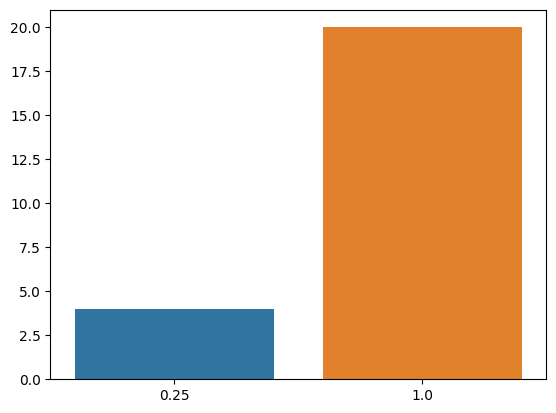

param_model__max_samples 

  param_model__max_samples  mean_test_score
0                     0.25        -1.224956
1                      1.0        -0.996253 

{'0.25': 1, '1.0': 23}


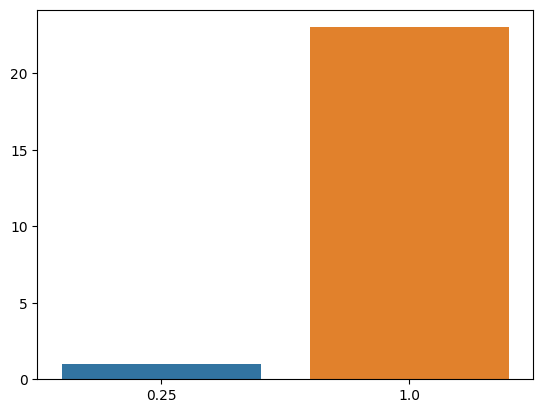

In [53]:
params = ['param_model__bootstrap', 'param_model__estimator',
       'param_model__max_features', 'param_model__max_samples',
       'param_model__n_estimators']

data = search_results.loc[search_results['param_model'] == 'BaggingRegressor']

for param in params:
    # skip those we already decided upon
    if param in ['param_model__bootstrap', 
                 'param_model__estimator', 
                 'param_model__n_estimators']:
        continue
    
    print(param,"\n")
    t = data.groupby(param)['mean_test_score'].mean().reset_index()
    print(t, "\n")
    feature_columns = [feature for feature in params if feature != param] 
    res = hf.optimal_config_count(data, feature_columns, 
                     param, 'mean_test_score')
    print(res)
    sns.barplot(x = list(res.keys()), y = list(res.values()))
    plt.show()

Lastly, I try to reduce the feature combinations for the Random Forest. 

In the top 10, **friedman and squared** are alternating. The mean for friedman is slighly higher than for squared,but squared wins in more combinations. I can not decide between them now. 

A **deeper model** seems slightly better than a shallower model according to all three comparison criteria. Therefore, I will explore the deeper models further. 

For  **min samples leaf** and **min samples split**, lower seems to be better. For the **maximum of features**, however, there should not be any constraint apparently. 

param_model__criterion 

  param_model__criterion  mean_test_score
0           friedman_mse        -0.897853
1          squared_error        -0.886280 

{'squared_error': 57, 'friedman_mse': 39}


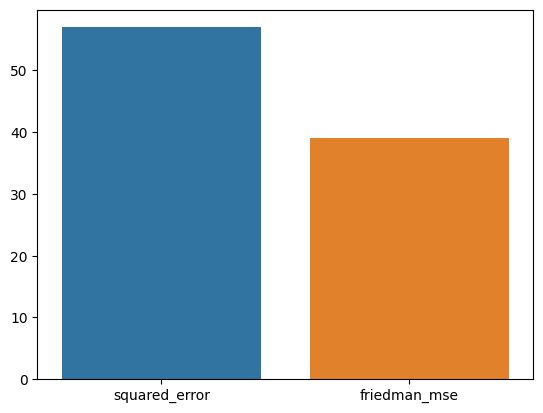

param_model__max_depth 

  param_model__max_depth  mean_test_score
0                     10        -0.905947
1                    100        -0.878828 

{'10': 35, '100': 61}


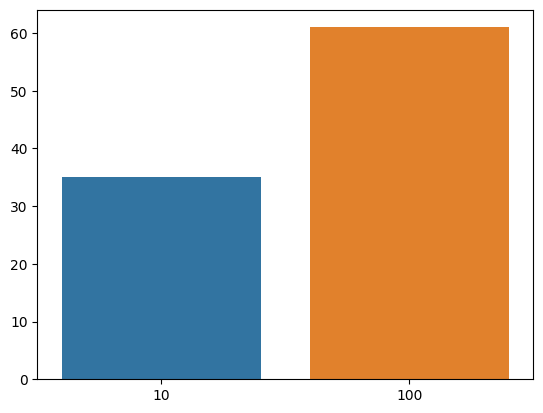

param_model__min_samples_leaf 

  param_model__min_samples_leaf  mean_test_score
0                             1        -0.885291
1                             4        -0.898947 

{'1': 69, '4': 27}


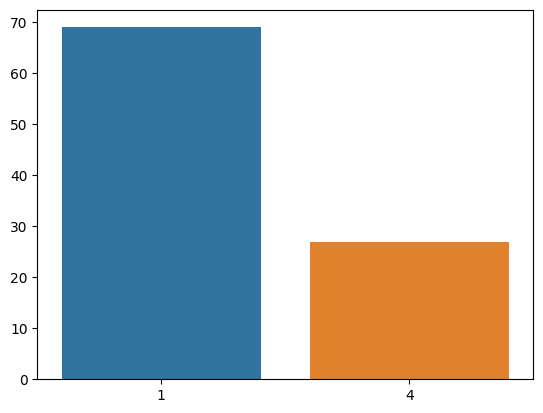

param_model__min_samples_split 

  param_model__min_samples_split  mean_test_score
0                             10        -0.919249
1                              2        -0.868504 

{'2': 62, '10': 34}


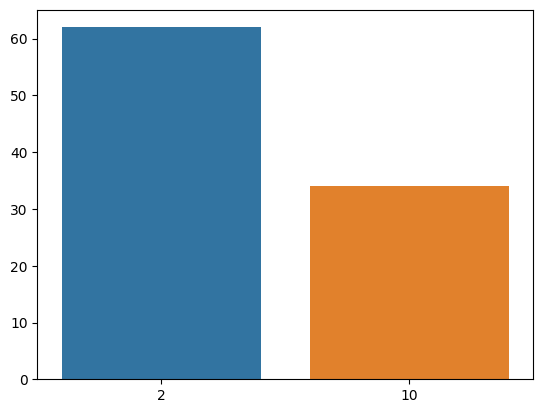

param_model__max_features 

  param_model__max_features  mean_test_score
0                      None        -0.769383
1                      log2        -1.030360
2                      sqrt        -1.037638 

{'sqrt': 0, 'log2': 0, 'None': 64}


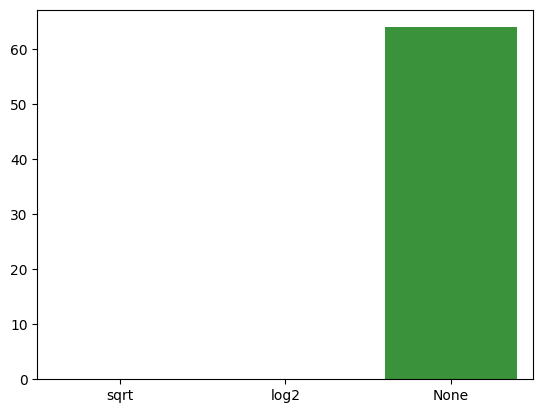

In [54]:
params = ['param_model__bootstrap', 'param_model__n_estimators',
       'param_model__criterion','param_model__max_depth', 
          'param_model__min_samples_leaf', 'param_model__min_samples_split',
         'param_model__max_features']

data = search_results.loc[search_results['param_model'] == 'RandomForestRegressor']

for param in params:
    # skip those we already decided upon
    if param in ['param_model__bootstrap', 
                 'param_model__n_estimators']:
        continue
    
    print(param,"\n")
    t = data.groupby(param)['mean_test_score'].mean().reset_index()
    print(t, "\n")
    feature_columns = [feature for feature in params if feature != param] 
    res = hf.optimal_config_count(data, feature_columns, 
                     param, 'mean_test_score')
    print(res)
    sns.barplot(x = list(res.keys()), y = list(res.values()))
    plt.show()

In [55]:
param_grid_2 = [
    {
        'model': [BaggingRegressor()],
        'model__n_estimators': [100, 250, 500, 750, 1000],
        'model__max_samples': [0.7, 0.85, 1.0],
        'model__max_features': [0.7, 0.85, 1.0],
    },
    {
        'model': [RandomForestRegressor(max_features = None)],
        'model__criterion': ["squared_error", "friedman_mse"],
        'model__n_estimators': [100, 250, 500, 750, 1000],
        'model__max_depth': [50, 75, 100],
        'model__min_samples_leaf': [1, 2],
        'model__min_samples_split': [2, 3, 4],
    }
]

grid = HalvingGridSearchCV(pipeline, 
                           param_grid_2, 
                           scoring=rmsle_scorer, 
                           cv=3, 
                           n_jobs = -1, 
                           verbose = 1, 
                           error_score='raise').fit(X_train, y_train)


print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 107
max_resources_: 8708
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 225
n_resources: 107
Fitting 3 folds for each of 225 candidates, totalling 675 fits
----------
iter: 1
n_candidates: 75
n_resources: 321
Fitting 3 folds for each of 75 candidates, totalling 225 fits
----------
iter: 2
n_candidates: 25
n_resources: 963
Fitting 3 folds for each of 25 candidates, totalling 75 fits
----------
iter: 3
n_candidates: 9
n_resources: 2889
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 4
n_candidates: 3
n_resources: 8667
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best cross-validation accuracy: -0.348
0
Test set score: -0.314
Best parameters: {'model': RandomForestRegressor(max_depth=75, max_features=None, n_estimators=500), 'model__criterion': 'squared_error', 'model__max_depth': 75, 'model__min_samples_leaf': 1, 'model__min_samples_split'

# Submission

In [56]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,atemp_imp,time,date,hour,month,day,year
0,2011-01-20 00:00:00,1,False,True,1,10.66,11.365,56.0,26.002700,11.365,00:00:00,2011-01-20,0,1,3,2011
1,2011-01-20 01:00:00,1,False,True,1,10.66,13.635,56.0,8.911686,13.635,01:00:00,2011-01-20,1,1,3,2011
2,2011-01-20 02:00:00,1,False,True,1,10.66,13.635,56.0,8.911686,13.635,02:00:00,2011-01-20,2,1,3,2011
3,2011-01-20 03:00:00,1,False,True,1,10.66,12.880,56.0,11.001400,12.880,03:00:00,2011-01-20,3,1,3,2011
4,2011-01-20 04:00:00,1,False,True,1,10.66,12.880,56.0,11.001400,12.880,04:00:00,2011-01-20,4,1,3,2011


In [57]:
X_test = test.loc[:, ~test.columns.isin(['casual', 
                                      'registered', 
                                      'total_shared',
                                     'datetime',
                                     'time',
                                     'atemp',
                                     'date'])]
X_test = column_trans.transform(X_test)

The distribution looks quite similar for both the test-set predicted and the train set actual data. This is promising. 

<Axes: ylabel='Count'>

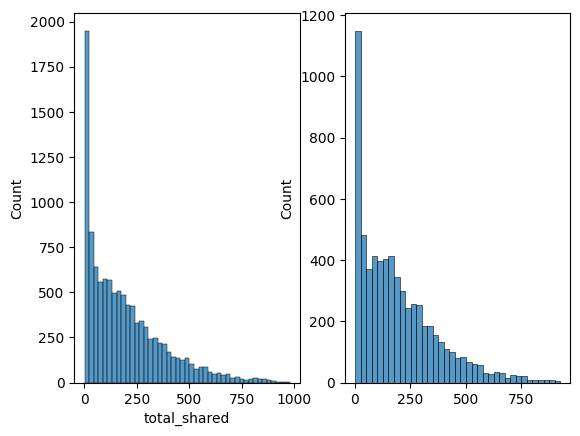

In [58]:
y_test = grid.predict(X= X_test)
_,(ax1,ax2)= plt.subplots(ncols=2)
sns.histplot(y, ax = ax1)
sns.histplot(y_test, ax = ax2)

In [59]:
submission=pd.DataFrame({'datetime':test['datetime'],'count':y_test})

submission.to_csv('submission.csv', index=False)